## FlowerDataset 102クラスの分類<br><br>EfficientNet

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from glob import glob
import timm
import timm.loss as tl

C:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
os.environ["PYTHONHASHSEED"] = "42"

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [4]:
def images_with_labels(data_type: str):
    data_dirs = [fr"C:\Users\PC_User\Python\Kaggle\Flower_Classification\{data_type}\{i+1}" for i in range(102)]
    images_with_labels = [(img_path, class_id + 1) 
                          for class_id, class_dir in enumerate(data_dirs)
                          for img_path in glob(os.path.join(class_dir, "*.jpg"))]
    return images_with_labels

In [5]:
common_transform = [
    A.Resize(height=224, width=224),  # Fixed input size
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet stats
    ToTensorV2()
]

train_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    *common_transform
])

val_transform = A.Compose([*common_transform])

class FlowerDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        self.image_label_pairs = image_label_pairs  # (image_path, label)
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
        image = np.array(Image.open(image_path).convert('RGB'))

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image.float(), torch.tensor(label).long()

In [6]:
train_dataset = FlowerDataset(images_with_labels("train"), transform=train_transform)
val_dataset = FlowerDataset(images_with_labels("valid"), transform=val_transform)
test_dataset = FlowerDataset(images_with_labels("test"), transform=val_transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 最初のバッチの画像を見てみる

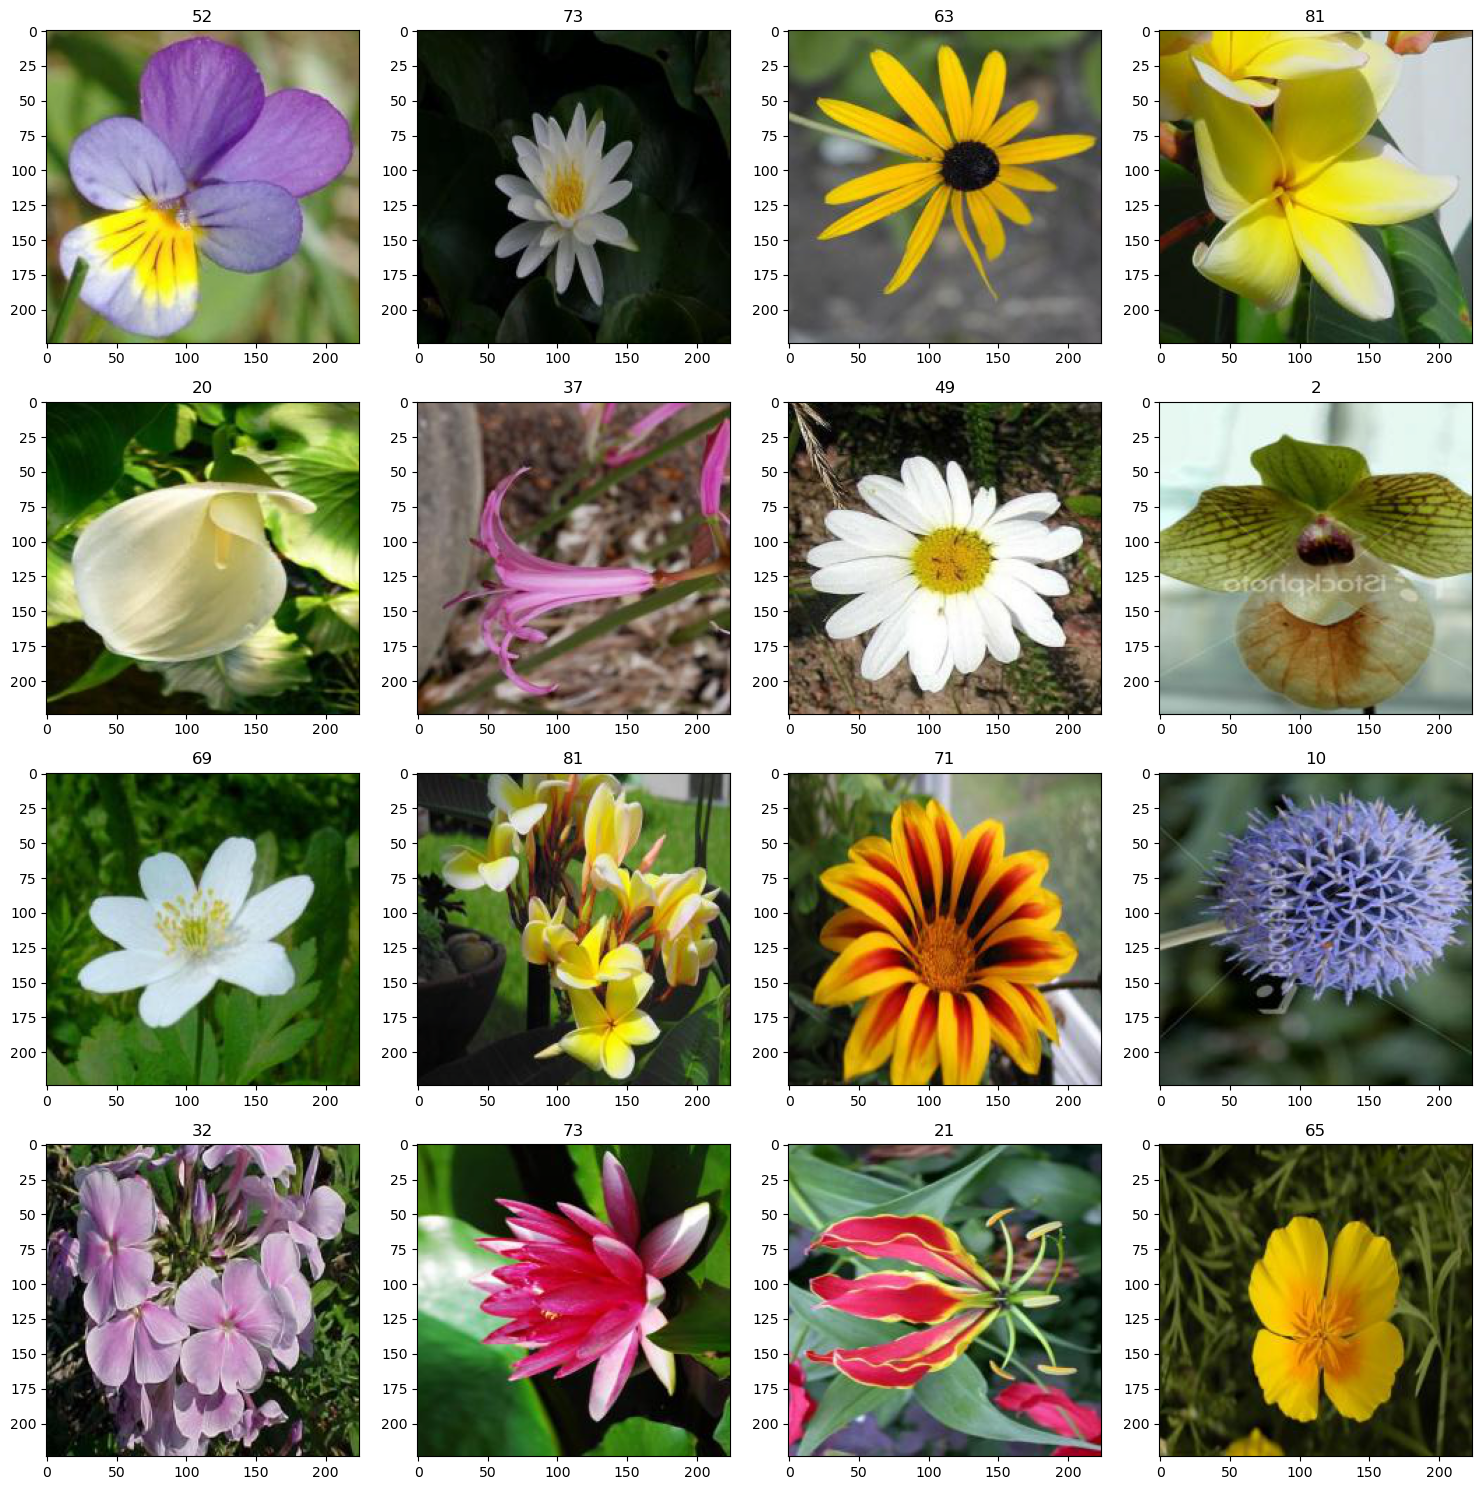

In [9]:
def denormalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.tensor(mean).view(-1, 1, 1).to(img.device)
    std = torch.tensor(std).view(-1, 1, 1).to(img.device)
    return img * std + mean

def show_image(image, label, ax):
    image = denormalize(image)
    image = torch.clamp(image, 0, 1)
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(f"{label}", fontsize=12)


fig, ax = plt.subplots(4, 4, figsize=(15, 15))
ax = ax.flatten()
for img_batch, label_batch in train_loader:
    for i in range(16):  
        img = img_batch[i]
        label = label_batch[i]
        show_image(img, label, ax[i])
    break
plt.tight_layout();

## 訓練

In [11]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    train_loss = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader)

def validate_one_epoch(model, loader, loss_fn):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to('cuda'), labels.to('cuda')
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loader)

### `CrossEntropyLoss` と `AsymmetricLossSingleLabel` で精度を比較する

In [13]:
def train(set_loss_type: int):
    
    model = timm.create_model('efficientnet_b0', pretrained=True)
    model.classifier.out_features = 102
    model = model.to('cuda')
    
    if set_loss_type == 1:
        loss_fn = nn.CrossEntropyLoss()
    elif set_loss_type == 2:
        loss_fn = loss_fn = tl.AsymmetricLossSingleLabel()
    else:
        raise ValueError("Unsupported loss name")
        return

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1)

    num_epochs = 30
    patience = 3
    patience_counter = 0
    best_val_loss = float('inf')
    history = {"train_loss": [], "val_loss": []}
    total_epochs = 0

    # 学習ループ
    for epoch in range(1, num_epochs + 1):
        total_epochs = epoch
        
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        val_loss = validate_one_epoch(model, val_loader, loss_fn)

        print(f"[{epoch:02d}] Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")
        scheduler.step(val_loss)

        # ロス記録
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        # 最良モデルの保存
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            torch.save(best_model_state, f'best_model{set_loss_type}.pth')
            print(f"\nBest model saved with validation loss: {best_val_loss:.5f}\n")
            patience_counter = 0  # リセット
        else:
            patience_counter += 1

        # 早期終了
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    plt.figure(figsize=(6, 3))
    plt.plot(np.arange(1, total_epochs+1), history["train_loss"], label='Train Loss')
    plt.plot(np.arange(1, total_epochs+1), history["val_loss"], label='Valid Loss')
    plt.legend(loc='upper right');

[01] Train Loss: 3.27959 | Val Loss: 0.82955

Best model saved with validation loss: 0.82955

[02] Train Loss: 0.45789 | Val Loss: 0.35852

Best model saved with validation loss: 0.35852

[03] Train Loss: 0.15813 | Val Loss: 0.26809

Best model saved with validation loss: 0.26809

[04] Train Loss: 0.09350 | Val Loss: 0.21467

Best model saved with validation loss: 0.21467

[05] Train Loss: 0.05546 | Val Loss: 0.21232

Best model saved with validation loss: 0.21232

[06] Train Loss: 0.04544 | Val Loss: 0.20210

Best model saved with validation loss: 0.20210

[07] Train Loss: 0.03053 | Val Loss: 0.20339
[08] Train Loss: 0.02952 | Val Loss: 0.19946

Best model saved with validation loss: 0.19946

[09] Train Loss: 0.02478 | Val Loss: 0.17646

Best model saved with validation loss: 0.17646

[10] Train Loss: 0.02704 | Val Loss: 0.18033
[11] Train Loss: 0.01852 | Val Loss: 0.17605

Best model saved with validation loss: 0.17605

[12] Train Loss: 0.04552 | Val Loss: 0.20520
[13] Train Loss: 0.

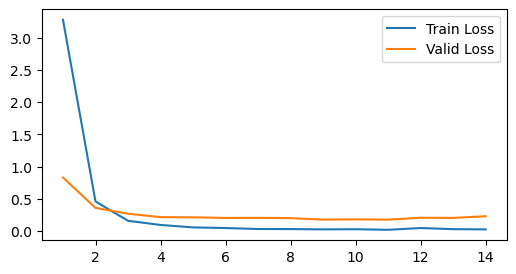

In [14]:
train(set_loss_type=1)

[01] Train Loss: 2.86225 | Val Loss: 0.62286

Best model saved with validation loss: 0.62286

[02] Train Loss: 0.30910 | Val Loss: 0.25973

Best model saved with validation loss: 0.25973

[03] Train Loss: 0.09674 | Val Loss: 0.21823

Best model saved with validation loss: 0.21823

[04] Train Loss: 0.05446 | Val Loss: 0.19058

Best model saved with validation loss: 0.19058

[05] Train Loss: 0.04290 | Val Loss: 0.18998

Best model saved with validation loss: 0.18998

[06] Train Loss: 0.02498 | Val Loss: 0.17270

Best model saved with validation loss: 0.17270

[07] Train Loss: 0.02864 | Val Loss: 0.18840
[08] Train Loss: 0.02200 | Val Loss: 0.15862

Best model saved with validation loss: 0.15862

[09] Train Loss: 0.01666 | Val Loss: 0.15836

Best model saved with validation loss: 0.15836

[10] Train Loss: 0.01784 | Val Loss: 0.19020
[11] Train Loss: 0.01491 | Val Loss: 0.16068
[12] Train Loss: 0.02149 | Val Loss: 0.15816

Best model saved with validation loss: 0.15816

[13] Train Loss: 0.

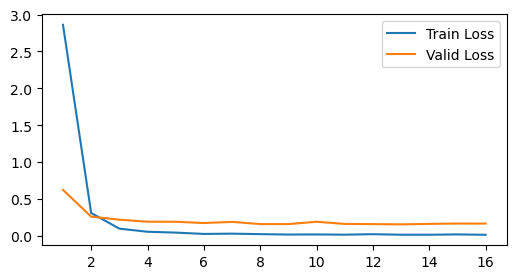

In [15]:
train(set_loss_type=2)

## Test

In [17]:
from sklearn.metrics import classification_report

def test(set_loss_type: int):
    if set_loss_type in [1, 2]:
        model = timm.create_model('efficientnet_b0', pretrained=False)
        model.classifier.out_features = 102
        model = model.to('cuda')
        model.load_state_dict(torch.load(f'best_model{set_loss_type}.pth'))
    else:
        print('Error')
        return

    model.eval()

    predict_labels = []
    true_labels = []

    with torch.no_grad():
        for img, label in test_loader:
            img = img.to('cuda')
            label = label.to('cuda')

            logits = model(img)

            pred = torch.argmax(logits, dim=1)
            predict_labels.append(pred.cpu().numpy())
            true_labels.append(label.cpu().numpy())

    true_labels = np.concatenate(true_labels, axis=0)
    predict_labels = np.concatenate(predict_labels, axis=0)
    report = classification_report(true_labels, predict_labels, digits=4)
    print(report)

In [18]:
test(set_loss_type=1)

              precision    recall  f1-score   support

           1     1.0000    0.9000    0.9474        10
           2     1.0000    0.9167    0.9565        12
           3     0.7333    0.8462    0.7857        13
           4     0.7857    0.7857    0.7857        14
           5     1.0000    0.8000    0.8889        20
           6     1.0000    1.0000    1.0000        15
           7     0.8462    1.0000    0.9167        11
           8     1.0000    1.0000    1.0000        23
           9     0.6000    1.0000    0.7500         3
          10     1.0000    1.0000    1.0000         9
          11     1.0000    0.9091    0.9524        22
          12     1.0000    0.9444    0.9714        18
          13     1.0000    0.9375    0.9677        16
          14     1.0000    1.0000    1.0000        13
          15     0.9167    1.0000    0.9565        11
          16     1.0000    1.0000    1.0000         8
          17     1.0000    1.0000    1.0000        24
          18     1.0000    

以下は、**難しいクラス（= F1スコアが特に低いクラス）**　をまとめた表です。F1スコアが特に **0.90未満** のクラスを抽出し、`precision`・`recall`・`support`（テストデータ数）とともに一覧にしています。

| Class | Precision | Recall | F1-Score | Support | コメント                     |
| ----- | --------- | ------ | -------- | ------- | ------------------------ |
| 3     | 0.7333    | 0.8462 | 0.7857   | 13      | Precisionがやや低い。分類が曖昧。    |
| 4     | 0.7857    | 0.7857 | 0.7857   | 14      | バランス良く低い。学習不足か？          |
| 9     | 0.6000    | 1.0000 | 0.7500   | 3       | サンプル数が少ない。               |
| 30    | 0.9524    | 0.8696 | 0.9091   | 23      | Recallがやや低く、取りこぼしあり。     |
| 31    | 1.0000    | 0.8000 | 0.8889   | 10      | Recallが低い。               |
| 32    | 0.7500    | 0.7500 | 0.7500   | 12      | 精度・再現率ともに低め。             |
| 36    | 0.9286    | 0.8125 | 0.8667   | 16      | Recallがやや弱い。             |
| 39    | 0.6923    | 0.8182 | 0.7500   | 11      | Precisionがかなり低い。誤分類あり。   |
| 40    | 1.0000    | 0.7222 | 0.8387   | 18      | Recallが低い。               |
| 43    | 0.7188    | 0.9583 | 0.8214   | 24      | Precisionが低い＝他クラスとの混同あり。 |
| 45    | 1.0000    | 0.7500 | 0.8571   | 12      | Recallがやや問題。             |
| 67    | 1.0000    | 0.7143 | 0.8333   | 14      | Recallに課題。               |
| 68    | 0.8000    | 0.8000 | 0.8000   | 10      | 全体的に低め。                  |
| 84    | 0.9474    | 0.9000 | 0.9231   | 20      | 少しRecallが低い。             |
| 85    | 1.0000    | 0.8462 | 0.9167   | 13      | Recallの低さが課題。            |
| 90    | 1.0000    | 0.8571 | 0.9231   | 28      | Recall低め。クラス内バラツキ？       |
| 96    | 0.8000    | 0.8889 | 0.8421   | 18      | Precisionに課題あり。          |
| 97    | 0.7857    | 0.7333 | 0.7586   | 15      | 両指標とも低く、難しいクラス。          |

In [19]:
test(set_loss_type=2)

              precision    recall  f1-score   support

           1     1.0000    0.9000    0.9474        10
           2     1.0000    1.0000    1.0000        12
           3     0.6667    0.7692    0.7143        13
           4     0.7500    0.8571    0.8000        14
           5     0.7200    0.9000    0.8000        20
           6     1.0000    1.0000    1.0000        15
           7     1.0000    0.9091    0.9524        11
           8     1.0000    1.0000    1.0000        23
           9     0.6000    1.0000    0.7500         3
          10     1.0000    1.0000    1.0000         9
          11     0.9524    0.9091    0.9302        22
          12     1.0000    0.9444    0.9714        18
          13     0.9375    0.9375    0.9375        16
          14     1.0000    1.0000    1.0000        13
          15     0.9167    1.0000    0.9565        11
          16     1.0000    0.8750    0.9333         8
          17     1.0000    1.0000    1.0000        24
          18     1.0000    

以下に、先ほど「難しい」と注目していたクラス（f1-score が特に低かったもの）について、`CrossEntropyLoss` と `AsymmetricLossSingleLabel` の分類結果を比較した表を示します。

---

### 注目クラス比較表（CrossEntropy vs Asymmetric）

| Class | CrossEntropy F1 | Asymmetric F1 | 差分 (↑:改善 / ↓:悪化) | コメント      |
| ----- | --------------- | ------------- | ---------------- | --------- |
| 3     | 0.6154          | 0.7143        | **↑ +0.0989**    | 改善したがまだ低い |
| 4     | 0.6000          | 0.8000        | **↑ +0.2000**    | 大幅に改善     |
| 5     | 0.6667          | 0.8000        | **↑ +0.1333**    | 改善傾向      |
| 9     | 0.6667          | 0.7500        | **↑ +0.0833**    | 軽度改善      |
| 31    | 0.5714          | 0.7273        | **↑ +0.1559**    | 改善あり      |
| 32    | 0.7500          | 0.7273        | ↓ -0.0227        | わずかに悪化    |
| 36    | 0.8000          | 0.8667        | **↑ +0.0667**    | 軽度改善      |
| 39    | 0.8889          | 0.7368        | ↓ -0.1521        | **悪化**    |
| 40    | 0.7500          | 0.8125        | **↑ +0.0625**    | 軽度改善      |
| 41    | 0.8000          | 0.8667        | **↑ +0.0667**    | 軽度改善      |
| 43    | 0.8462          | 0.8302        | ↓ -0.0160        | ほぼ横ばい     |
| 67    | 0.8571          | 0.6667        | ↓ -0.1904        | **顕著に悪化** |
| 68    | 0.8571          | 0.8421        | ↓ -0.0150        | ほぼ変化なし    |
| 85    | 0.7778          | 0.8966        | **↑ +0.1188**    | 明確に改善     |
| 87    | 0.7826          | 0.8889        | **↑ +0.1063**    | 明確に改善     |
| 96    | 0.8571          | 0.8571        | ±0.0000          | 同じ        |
| 97    | 0.7059          | 0.7333        | **↑ +0.0274**    | 微改善       |
| 99    | 0.9286          | 0.9375        | **↑ +0.0089**    | ほぼ同じ      |

---

### 総評：

* **多くの難クラス（3, 4, 5, 31, 85, 87など）でf1-scoreが大きく改善**しました。
* **Class 67やClass 39ではf1-scoreが顕著に悪化**しており、Asymmetric損失の偏りが影響している可能性があります。
* **Class 32, 43, 68などは微悪化または変化が小さい**ため、学習の揺らぎの範囲とも考えられます。

難しいクラスに関しては全体的に改善傾向だが、全体性能でいうと悪化している。難クラス重視の損失関数（AsymmetricLoss系）は、そのクラスの誤分類減少に寄与する代わりに、簡単なクラスや多数クラスに対しては過学習や過剰調整で性能低下を招くケースがある。**トレードオフの関係**